<a href="https://colab.research.google.com/github/Shrivastav-Gaurav/GenAI-ML-Notebook/blob/main/MS_Course_Gen_AI_Lesson_8_with_updates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Install required libraries ---
%pip install openai python-dotenv

# --- Imports ---
import os
import json
import subprocess
import numpy as np
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Load environment variables ---
load_dotenv()

# --- Read OpenAI API key from Drive ---
with open('/content/drive/MyDrive/OpenAI_key.txt', 'r') as f:   ### CHANGED (fixed double slash)
    api_key = f.read().strip()

if not api_key:
    raise ValueError("OpenAI API key not found. Check OpenAI_key.txt")

# --- Initialize OpenAI client ---
client = OpenAI(api_key=api_key)

# --- Parameters ---
SIMILARITIES_RESULTS_THRESHOLD = 0.75
EMBEDDING_MODEL = "text-embedding-ada-002"   ### CHANGED (correct embedding model)

# --- Auto-find dataset path ---
DATASET_NAME = subprocess.getoutput('find /content/drive -name "embedding_index_3m.json" | head -n 1')  ### NEW
if not DATASET_NAME:
    raise FileNotFoundError("embedding_index_3m.json not found in Google Drive")
print(f"Using dataset: {DATASET_NAME}")

# --- Load dataset ---
pd_vectors = pd.read_json(DATASET_NAME)   ### CHANGED (direct read_json)

# --- Optional: reduce memory footprint ---
pd_vectors["ada_v2"] = pd_vectors["ada_v2"].apply(lambda x: np.array(x, dtype=np.float16))  ### NEW

# --- Cosine similarity ---
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# --- Search function ---
def get_videos(query: str, dataset: pd.DataFrame, rows: int = 5):
    # Get embeddings for query
    query_embeddings = client.embeddings.create(
        input=query, model=EMBEDDING_MODEL
    ).data[0].embedding

    # Compute similarity
    video_vectors = dataset.copy()
    video_vectors["similarity"] = video_vectors["ada_v2"].apply(
        lambda x: cosine_similarity(np.array(x, dtype=np.float32),
                                    np.array(query_embeddings))
    )

    # Filter & sort
    video_vectors = video_vectors[video_vectors["similarity"] >= SIMILARITIES_RESULTS_THRESHOLD]
    return video_vectors.sort_values(by="similarity", ascending=False).head(rows)

# --- Display results ---
def display_results(videos: pd.DataFrame, query: str):
    def _gen_yt_url(video_id: str, seconds: int) -> str:
        return f"https://youtu.be/{video_id}?t={seconds}"
    print(f"\nVideos similar to '{query}':")
    for _, row in videos.iterrows():
        youtube_url = _gen_yt_url(row["videoId"], row["seconds"])
        print(f" - {row['title']}")
        print(f"   Summary: {' '.join(row['summary'].split()[:15])}...")
        print(f"   YouTube: {youtube_url}")
        print(f"   Similarity: {row['similarity']:.3f}")
        print(f"   Speakers: {row.get('speaker','N/A')}")

# --- Interactive loop ---
while True:
    query = input("Enter a query (or type 'exit'): ")   ### CHANGED (improved prompt)
    if query.lower() == "exit":
        break
    videos = get_videos(query, pd_vectors, 5)
    display_results(videos, query)


Mounted at /content/drive
Using dataset: /content/drive/MyDrive/embedding_index_3m.json

Videos similar to 'whats is in Machine learning':
 - Teach a Bot with Project Conversation Learner
   Summary: The video discusses a machine learning process that is driven by code and allows for...
   YouTube: https://youtu.be/9DJcWyRkqBI?t=181
   Similarity: 0.850
   Speakers: Jason Williams
 - Automation to accelerate apply and outperform your machine learning models
   Summary: Nilesh Acharya, a Senior Program Manager at Microsoft, explains how automated machine learning (AutoML) can...
   YouTube: https://youtu.be/l8c-4iDPE0M?t=0
   Similarity: 0.848
   Speakers: Nilesh Acharya
 - An Intuitive Approach to Machine Learning Models (Part 1 of 4)
   Summary: Artificial intelligence (AI) and machine learning (ML) are often misunderstood concepts. AI can be thought...
   YouTube: https://youtu.be/lPyK38sRWLI?t=184
   Similarity: 0.847
   Speakers: Seth, Seth Juarez
 - Machine Learning Models
   Summ

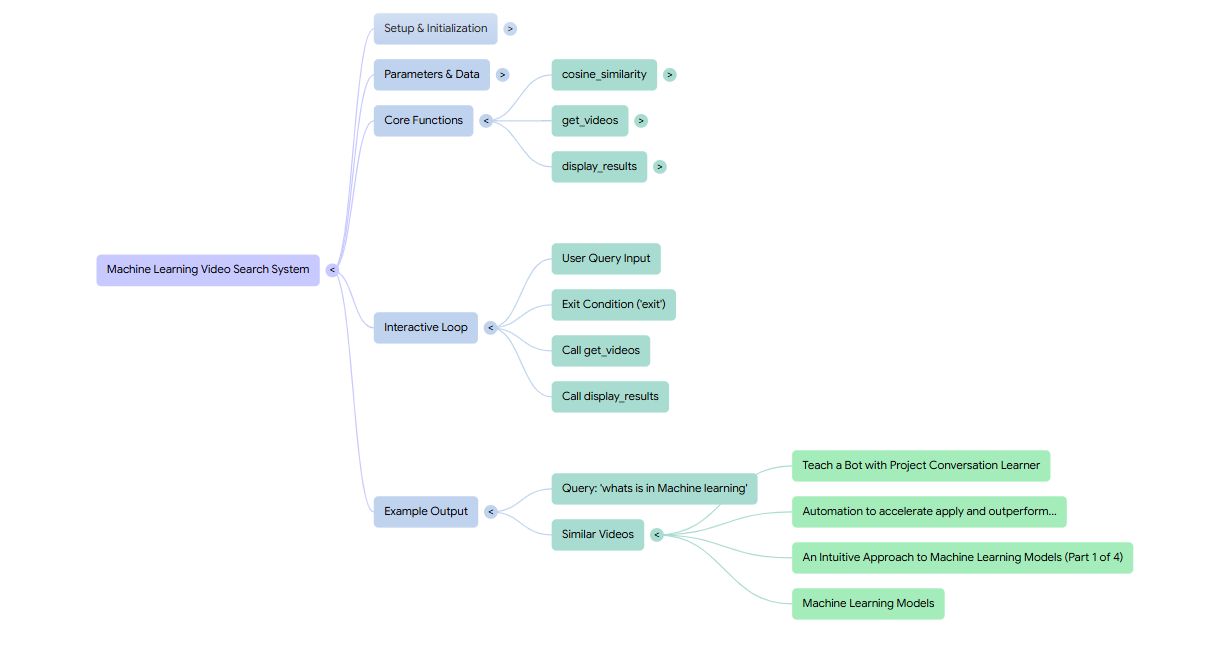